In [5]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

### Conceptos básicos, definir, crear y contraer Tensor Networks


[[ 0.      +0.j  0.707107+0.j]
 [-0.707107+0.j  0.      +0.j]]


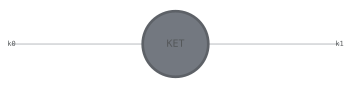

In [6]:
data = qu.bell_state('psi-').reshape(2, 2)
print(data)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket.draw()

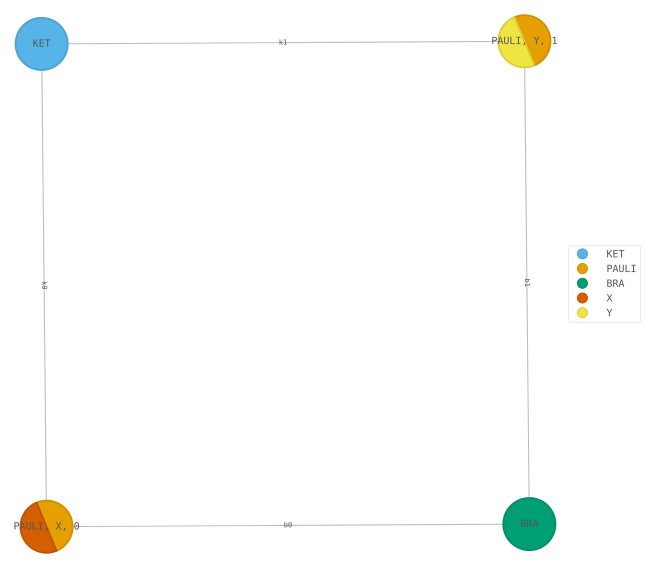

In [23]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])
TN = ket.H & X & Y & bra
TN.draw(color=['KET', 'PAULI', 'BRA', 'X', 'Y'], figsize=(10, 10), show_inds='all')


In [24]:
C=TN ^ ...
type(C)

complex

In [23]:
C.data

array([[ 0.20881482+0.12526468j, -0.07039511+0.48526749j],
       [-0.3136296 +0.04960175j, -0.288013  -0.12841251j]])

### Optimización


Los pasos básicos para realizar optimizaciones de TN empleando Quimb son los siguientes:
- Definir un tensor network 
- Si es un tensor network definir el conjunto de etiquetas que especifiquen los tensores a optimizar, mantener constantes o compartir parámetros en común.
- Opcionalmente normalizar la red neuronal.
- Definir una función de pérdida que tome un tn y devuelva un escalar real a minimizar.
- Realizar la optimización

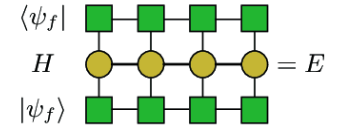

In [62]:
from IPython.display import Image, display

# Para una imagen local
display(Image(filename='valoresperado.png'))

Definimos el TN

In [27]:
L = 10
D = 2
pbc = True

# create a random MPS as our initial target to optimize
psi = qtn.MPS_rand_state(L, bond_dim=D)

# create the hamiltonian MPO, this is a constant TN not to be optimized
ham = qtn.MPO_ham_heis(L, cyclic=pbc)
psi.arrays

(array([[0.75316108, 0.72662977],
        [0.54960185, 0.45296158]]),
 array([[[-7.47369391e-01, -3.61436263e-01],
         [-6.15687690e-01,  8.54546397e-01]],
 
        [[ 1.34751482e+00,  2.69530720e-04],
         [-5.78887857e-01, -2.88109728e-01]]]),
 array([[[-0.17540276,  0.86516136],
         [ 0.67848343,  0.07705275]],
 
        [[ 0.39925611,  0.5662825 ],
         [ 0.5965645 , -0.00510684]]]),
 array([[[ 0.16688181,  0.08707269],
         [ 0.89451678,  0.23995172]],
 
        [[ 0.12274707,  0.85028085],
         [ 0.65646675, -0.38630518]]]),
 array([[[-0.22280996,  0.55089879],
         [-0.77258251, -1.05284919]],
 
        [[ 0.49284   , -0.72750768],
         [ 0.39508091,  1.13032662]]]),
 array([[[-0.53780665, -0.84569457],
         [-0.41134097, -0.22229351]],
 
        [[-0.62880131,  0.30687614],
         [-0.98989512, -0.29354598]]]),
 array([[[ 0.45077236, -0.4067468 ],
         [-1.10805954, -0.13840741]],
 
        [[-0.89088546,  0.14901279],
         [-0.5

Definimos la función de normalización y la de pérdida

In [71]:
def norm_fn(psi):
    # we could always define this within the loss function, but separating it
    # out can be clearer - it's also called before returning the optimized TN
    nfact = (psi.H @ psi)**0.5
    return psi.multiply(1 / nfact, spread_over='all')


def loss_fn(psi, ham):
    b, h, k = qtn.tensor_network_align(psi.H, ham, psi)
    energy_tn = b | h | k
    return energy_tn ^ ...

In [72]:
loss_fn(norm_fn(psi), ham)

-0.5307330509825465

In [73]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    psi,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"ham": ham},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    # which gradient computation backend to use
    #autodiff_backend="jax",
)
tnopt

<TNOptimizer(d=232, backend=jax)>

In [74]:
psi_opt = tnopt.optimize(1000)

-12.329798698425 [best: -12.329798698425] : : 1001it [00:08, 121.10it/s]                        


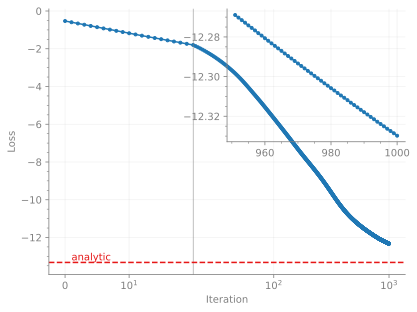

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Iteration', ylabel='Loss'>)

In [75]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

In [52]:
psi_opt = tnopt.get_tn_opt()
psi_opt.arrays


(array([[-0.50657433,  0.31905568],
        [ 1.2043214 , -0.17042956]], dtype=float32),
 array([[[ 0.9524714 , -0.15142041],
         [-1.471302  ,  0.15447417]],
 
        [[ 0.09646811, -0.41584462],
         [-0.61690754,  0.72784066]]], dtype=float32),
 array([[[-0.16917442,  1.2776936 ],
         [ 0.11419164,  0.5154542 ]],
 
        [[ 1.6945027 ,  0.6317401 ],
         [ 0.48830634, -0.26749223]]], dtype=float32),
 array([[[-0.47819915, -0.22014181],
         [-0.27208385,  0.9464061 ]],
 
        [[-0.41685858,  0.31596187],
         [ 1.2828494 ,  0.1206204 ]]], dtype=float32),
 array([[[ 0.17886169, -0.80058587],
         [-0.17642689,  0.04621746]],
 
        [[-0.77016723,  0.63471884],
         [-0.5449941 , -0.77258056]]], dtype=float32),
 array([[[ 0.34257445, -1.3479652 ],
         [ 0.40147096,  0.5954084 ]],
 
        [[ 0.9264602 , -1.1830088 ],
         [-0.0366918 ,  0.5216579 ]]], dtype=float32),
 array([[[-0.04623874,  0.05105821],
         [-0.475458  , -0.420

In [53]:
import autoray as ar

rng = ar.do('random.default_rng', 42, like="numpy")

circ = qtn.Circuit(2)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 0, parametrize=True)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 1, parametrize=True)
circ.cnot(0, 1)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 0, parametrize=True)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 1, parametrize=True)

H = qu.ham_heis(2).astype("complex128")

def loss(circ, H):
    en = circ.local_expectation(H, (0, 1), simplify_sequence="ADCRS")
    # we use `autoray.do` to allow arbitrary autodiff backends
    return ar.do("real", en)

tnopt = qtn.TNOptimizer(
    circ,
    loss,
    loss_constants=dict(H=H),
    # because we are using dynamic (entry dependent) simplification
    autodiff_backend="autograd",
)
circ_opt = tnopt.optimize(10)

-0.749999999208 [best: -0.749999999208] : : 13it [00:01, 10.47it/s]                      


In [54]:
circ_opt.gates

(<Gate(label=U3, params=[4.71234134 2.55777369 5.39472984], qubits=(0,), parametrize=True))>,
 <Gate(label=U3, params=[3.14157063 0.52032894 6.13001603], qubits=(1,), parametrize=True))>,
 <Gate(label=CNOT, params=[], qubits=(0, 1))>,
 <Gate(label=U3, params=[4.20005643 5.20517656 0.60518082], qubits=(0,), parametrize=True))>,
 <Gate(label=U3, params=[2.08314126 2.06360383 6.30453863], qubits=(1,), parametrize=True))>)

### Computación cuántica

In [59]:
%config InlineBackend.figure_formats = ['svg']

import random
import quimb as qu
import quimb.tensor as qtn

N = 4
circ = qtn.Circuit(N)

# randomly permute the order of qubits
regs = list(range(N))
random.shuffle(regs)

# hamadard on one of the qubits
circ.apply_gate('H', regs[0])

# chain of cnots to generate GHZ-state
for i in range(N - 1):
    circ.apply_gate('CNOT', regs[i], regs[i + 1])

# apply multi-controlled NOT
circ.apply_gate('X', regs[-1], controls=regs[:-1])

# sample it a few times
for b in circ.sample(1):
    print(b)

0000


In [60]:
circ.to_dense()

[[0.707107+0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.707107+0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]
 [0.      +0.j]]

##### Pasos a realizar:

- Contruir la TN de la representación del circuito, esto incluye implementar el estado inicial, añadir tensores que representen las puertas y realizar posibles low-rank descomposiciones que puedan ser beneficiosas.
- Formar el TN de la cantidad que desees computar, ya sea, la función de onda, un valor esperado local o una matriz densidad, una probabilidad marginal, imitar un computador real o la computar la fidelidad.
- Computar simplificaciones locales de la TN para simplificar la contracción
- Encontrar un camino de contracción lo más óptimo posible para este tensor simplificado, lo bueno de este paso es que se comprueba la memoria del tensor posterior antes de realizar la contracción.
- Desmenuzar el proceso de contracción para que se más llevadero y ocupe menos en memoria.
- Realizar la contracción, en este momento los tensores deberían ser relativamente pequeños y se pueden enviar a una librería que pueda realizar las computaciones que haga uso de una GPU.